# Example 1

> This example will demonstrate a TEF analysis carried out for the Persian Gulf using data from Lorenz et al. (2020).
> 

In [32]:
from TotalExchangeFlow.tef_core import *
import matplotlib.pyplot as plt
import xarray as xr

import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
import gsw as gsw

In [33]:
ds_winter = xr.open_dataset("data/SoH_2_2011_01.nc").load() #exchange flow in Strait of Hormuz winter
ds_summer = xr.open_dataset("data/SoH_2_2011_01.nc")        #exchange flow in Strait of Hormuz summer
ds_2d_winter = xr.open_dataset("data/Surface_2011_01.nc")   #SST and SSS winter
ds_2d_summer = xr.open_dataset("data/Surface_2011_08.nc")   #SST and SSS summer

In [34]:
ds_2d = xr.concat([ds_2d_winter, ds_2d_summer], dim = "time").squeeze()

To get an overview about the area and the model domain, we first plot the Sea Surface Temperature (SST) and Sea Surface Salinity (SSS) during winter and summer (one daily mean value).

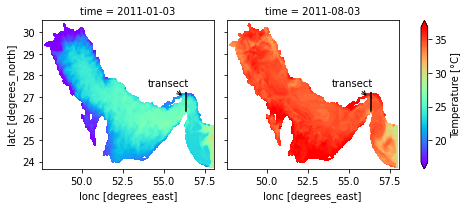

In [35]:
ds_2d.temp.attrs["long_name"] = "Temperature"
ds_2d.temp.attrs["units"] = "°C"

g = ds_2d.temp.plot(col = "time", cmap = "rainbow", robust = True)

for ax in (g.axes.flat):
    ax.annotate('transect',xy=(56.2,27.),xytext=(54,27.5),arrowprops=dict(arrowstyle='->'))
    ax.plot([ds_winter.lonc.values,ds_winter.lonc.values],[ds_winter.latc.values[0],ds_winter.latc.values[-1]],color='k')

One can see that the Persian Gulf shows a large seasonal cycle in SST, varying from below 16°C in January to values greater than 36°C in August. 

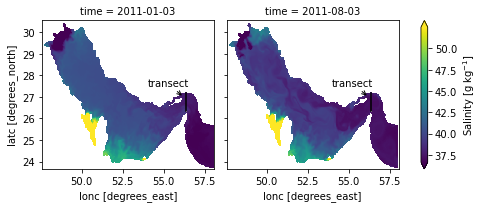

In [36]:
ds_2d.salt.attrs["long_name"] = "Salinity"
ds_2d.salt.attrs["units"] = "g kg$^{-1}$"

g = ds_2d.salt.plot(col = "time", cmap = "viridis", robust = True)
for ax in (g.axes.flat):
    ax.annotate('transect',xy=(56.2,27.),xytext=(54,27.5),arrowprops=dict(arrowstyle='->'))
    ax.plot([ds_winter.lonc.values,ds_winter.lonc.values],[ds_winter.latc.values[0],ds_winter.latc.values[-1]],color='k')

The salinity shows regional differences with the Shatt Al Arab river plume in the north west and greatest surface salinities in the south. Now let's explore the exchange flow.

**In summary**

One can see that the Persian Gulf shows a large seasonal cycle in SST, varying from below 16°C in January to 
values greater than 36°C in August. The salinity shows regional differences with the Shatt Al Arab river plume in the north west and greatest surface salinities in the south.
Now let's explore the exchange flow. 

In [37]:
tef = TEF_object(ds = ds_winter)
tef.set_up()

**Note**: Minus sign for velx3d since negative velocities flow into the Glf and should be therefore counted as an inflow which is defined as positive!

**Note**: Calculation will around 3 minutes.

### TEF analysis

Lets start by calculating the volume transport across the transect. 

Our dataset contains 3D velocity fields `velx3d`,

the cell height defined by `hn`,

and the width of the cell that is given by the transect `dyc`.


In [38]:
tef.ds["volume_transport"] = -tef.ds.velx3d*tef.ds.hn*tef.ds.dyc

We continue by calculating the same transport terms for salt and temperature.

In [39]:
# tef.calc_volume_transport(-tef.ds.velx3d, tef.ds.hn, tef.ds.dyc) # delete from calc

In [40]:
tef.ds["salt_transport"]   = -tef.ds.salt*tef.ds.velx3d*tef.ds.hn*tef.ds.dyc
tef.ds["temp_transport"]   = -tef.ds.temp*tef.ds.velx3d*tef.ds.hn*tef.ds.dyc

Now we use the `pyTEF` sort functions to sort the transports into salt and/or temperature space. 

In [41]:
out1d_vol_transport_s  = tef.sort_1dim(sort_by_variable = tef.ds.salt,
                                       transport = tef.volume_transport,
                                       N = 100, minmaxrange=(36,41))

100%|██████████| 100/100 [00:00<00:00, 161.39it/s]


In the upper cell we decided to sort the volume transport in terms of salinity coordinates. 

With `N = 100` we choose 100 discrete salinity bins ranging from $S_{min} = 36$ g kg$^{-1}$ to $S_{max} = 41$ g kg $^{-1}$ which is defined by using `minmaxrange`.

We continue by using the same approach for the other transport terms.

In [42]:
# tef.salt_transport = -tef.ds.salt*tef.ds.velx3d*tef.ds.hn*tef.ds.dyc
# tef.temp_transport = -tef.ds.temp*tef.ds.velx3d*tef.ds.hn*tef.ds.dyc
out1d_salt_transport_s = tef.sort_1dim(sort_by_variable = tef.ds.salt,
                                       transport = tef.salt_transport,
                                       N = 100, minmaxrange = (36,41))

out1d_vol_transport_t  = tef.sort_1dim(sort_by_variable = tef.ds.temp,
                                       transport = tef.volume_transport,
                                       N = 100, minmaxrange = (18,36))

out1d_temp_transport_t = tef.sort_1dim(sort_by_variable=tef.ds.temp,
                                       transport = tef.temp_transport,
                                       N = 100, minmaxrange = (18,36))

100%|██████████| 100/100 [00:00<00:00, 161.64it/s]


TODO:

Once the sorting is ready you will end up with a xarray dataset. For example the volume transport sorted by salinity coordinates contains: 

`q` - volume transport per salinity class; the units are $m^3 s^{-1} (g / kg)^{-1}$ (see ...)

`Q` - intergrated volume transport above a salinity threshold; the units are $m^3 s^{-1}$ (see ...)

The coordinates are now showing the respective salinity class/bin.

`var_q` - correspond to the salinity bin values for `q`

`var_Q` - correspond to the salinity bin values for `Q`

In [43]:
out1d_vol_transport_s

<xarray.Dataset>
Dimensions:  (time: 744, var_Q: 101, var_q: 100)
Coordinates:
  * time     (time) datetime64[ns] 2011-01-01T01:00:00 ... 2011-02-01
  * var_q    (var_q) float64 36.02 36.07 36.12 36.17 ... 40.83 40.88 40.93 40.98
  * var_Q    (var_Q) float64 36.0 36.05 36.1 36.15 ... 40.85 40.9 40.95 41.0
Data variables:
    q        (time, var_q) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Q        (time, var_Q) float64 1.193e+06 1.193e+06 1.193e+06 ... 0.0 0.0 0.0

Let's first have a look a the mean transports for January 2011 by averaging over the time dimension.

In [44]:
q_s = out1d_vol_transport_s.q.mean('time')
q_t = out1d_vol_transport_t.q.mean('time')

Q_s = out1d_vol_transport_s.Q.mean('time')
Q_t = out1d_vol_transport_t.Q.mean('time')

Qs_s = out1d_salt_transport_s.Q.mean('time')
Qt_t = out1d_temp_transport_t.Q.mean('time')

Text(0, 0.5, 'Salinity')

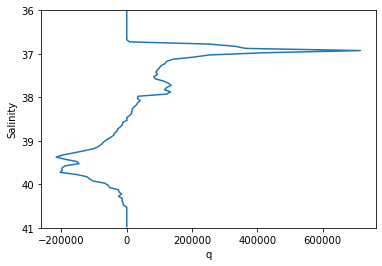

In [45]:
plt.plot(q_s, q_s.var_q)
plt.ylim([41, 36])
plt.xlabel("q")
plt.ylabel("Salinity")

In the figure you can see that the inflow (positive) occurs at lower salinity values and the outflow (negative) occurs at higher salinity values, following an inverse estuarine circulation. To quantify the exchange flow TEF uses bulk values for inflow and outflow properties, which are computed in the following.

In [46]:
bulk_vol_s = tef.calc_bulk_values(out1d_vol_transport_s.var_Q,
                                  Q_s)

100%|██████████| 2/2 [00:00<00:00, 1325.01it/s]


The `pyTEF` function `calc_bulk_values` uses the integrated transport `Q` to evaluate maxima and minima which are then used to compute the bulk values. The bulk values allow to characterize the exchange flow of a given estuary in terms of single values. In this example the bulk values are volume transports. (see ... )bulk_vol_s

In [47]:
bulk_vol_s

<xarray.Dataset>
Dimensions:  (m: 1, n: 1, o: 3)
Coordinates:
  * m        (m) int64 0
  * n        (n) int64 0
  * o        (o) int64 0 1 2
Data variables:
    Qin      (m) float64 2.351e+05
    Qout     (n) float64 -1.705e+05
    divval   (o) float64 36.7 38.55 40.5
    index    (o) int64 14 51 90

`Qin` - bulk value for inflow; here volume transport

`Qout` - bulk values for outflow; here volume transport

`divval`- values that delimit inflow and outflow (see plot below)

`index` - index of salinity class that correspond to divval.

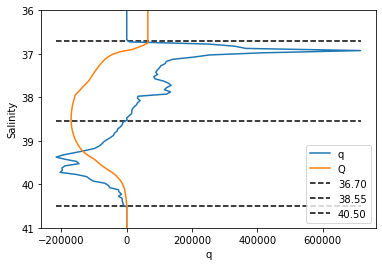

In [48]:
plt.plot(q_s, q_s.var_q, label = "q")
plt.ylim([41, 36])
for val in bulk_vol_s.divval:
    plt.hlines(val,
           xmin =q_s.min(),
           xmax = q_s.max(),
           color = "black",
           ls = "--", 
           label = "{:.2f}".format(val.values))
plt.plot(Q_s, Q_s.var_Q, label = "Q")
plt.legend(loc="lower right")
plt.xlabel("q")
plt.ylabel("Salinity");

As you can see the dividing values correspond the the extrema of `Q` and the zero crossings of `q`. They seperate inflow and outflow. These are used for computing the bulk values (Lorenz et al. (2019)). In the following we continue similarly, for the other transport terms.

In [49]:
bulk_salt_s = tef.calc_bulk_values(out1d_salt_transport_s.var_Q,
                                   Qs_s,
                                   index = bulk_vol_s.index)

100%|██████████| 2/2 [00:00<00:00, 1294.94it/s]


The cell above we compute the bulk values for salt transport, by providing the value indicies from the example above (`index = bulk_vol_s.index`), which will save computational resources. So this is optional, and would work without providing the `index` option above.

In [50]:
bulk_vol_t = tef.calc_bulk_values(out1d_vol_transport_t.var_Q, Q_t)

bulk_temp_t = tef.calc_bulk_values(out1d_temp_transport_t.var_Q,
                                   Qt_t,
                                   index=bulk_vol_t.index)

print('Q_in: {:.2f} m3s-1 and Q_out {:.2f} m3s-1 from the isohaline TEF, Q_net: {:.2f} m3s-1'
      .format(bulk_vol_s.Qin.values[0],bulk_vol_s.Qout.values[0],bulk_vol_s.Qin.values[0]+bulk_vol_s.Qout.values[0]))
print('Q_in: {:.2f} m3s-1 and Q_out {:.2f} m3s-1 from the isothermal TEF, Q_net: {:.2f} m3s-1'
      .format(bulk_vol_t.Qin.values[0],bulk_vol_t.Qout.values[0],bulk_vol_t.Qin.values[0]+bulk_vol_t.Qout.values[0]))

100%|██████████| 2/2 [00:00<00:00, 1317.10it/s]

Q_in: 235064.75 m3s-1 and Q_out -170513.32 m3s-1 from the isohaline TEF, Q_net: 64551.43 m3s-1
Q_in: 174325.13 m3s-1 and Q_out -109773.70 m3s-1 from the isothermal TEF, Q_net: 64551.43 m3s-1


One can see that the sorting by temperature and salt gives different bulk values. The reason will be discussed in the upcomming 2 dimensional analysis of the bulk values. By calculating the fraction of the salt and volume transports one finds the bulk salinities of inflow and outflow. The same applies for temperature.

In [51]:
s_in  = bulk_salt_s.Qin / bulk_vol_s.Qin
s_out = bulk_salt_s.Qout / bulk_vol_s.Qout

t_in  = bulk_temp_t.Qin / bulk_vol_t.Qin
t_out  = bulk_temp_t.Qout / bulk_vol_t.Qout

print('s_in: {:.2f} g/kg and s_out: {:.2f} g/kg'.format(s_in.values[0],s_out.values[0]))
print('t_in: {:.2f} °C and t_out: {:.2f} °C'.format(t_in.values[0],t_out.values[0]))

s_in: 37.21 g/kg and s_out: 39.48 g/kg
t_in: 24.85 °C and t_out: 26.76 °C


In summary, the monthly averaged exchange flow can be characterized as a two layer exchange flow with inflowing colder and less saline water and with outflowing warmer and more saline water.

### 2-dimensional analysis

`pyTEF` also allows to sort by 2 variables. Here we chose to sort by salinity and temperature, which will result in a 2D-dimensional array. 

**Note**: When you are using two variables, you have to provide `minmaxrange` and `minmaxrange2`.

In [52]:
out2d = tef.sort_2dim(sort_by_variable  = tef.ds.temp,  #first variable will be y axis
                      sort_by_variable2 = tef.ds.salt,  #second variable will be x axis
                      transport = tef.volume_transport,
                      N = 100, minmaxrange = (18,36), minmaxrange2=(36,41))

100%|██████████| 100/100 [01:12<00:00,  1.39it/s]


In [53]:
q_2d_mean = out2d.q2.mean('time')

First compute the sea water density with the Gibbs Sea Water package based on TEOS10

In [54]:
dens = np.zeros((len(out2d.var_q), len(out2d.var_q2)))

for i in range(len(out2d.var_q2)):
    dens[:, i] = gsw.rho(out2d.var_q2[i],
                         out2d.var_q,
                         0) #0 pressure since the model uses potential temperature
dens = dens - 1000.0

In the following the monthly averaged the 2 dimensional `q` (sorted by temperature **and** salt) as well as the monthly averaged 1D `q` profiles are shown.

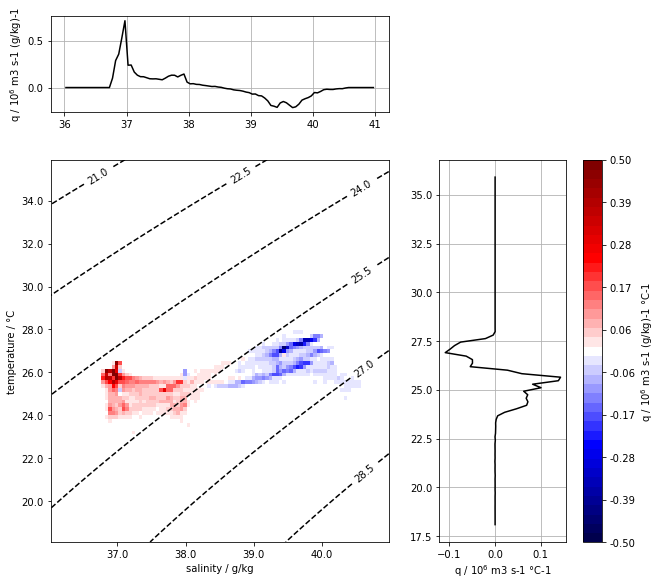

In [55]:
vmax = 0.5

fig = plt.figure()
gs = gridspec.GridSpec(2, 2,width_ratios=[2, 1],height_ratios=[1, 4])

ax1 = plt.subplot(gs[0])#top left
ax2 = plt.subplot(gs[1])#top right
ax3 = plt.subplot(gs[2])#bottom left (main panel)
ax4 = plt.subplot(gs[3])#bottom right
fig.set_size_inches(10,10)

#plot the T-S TEF in main panel with density contours
pcol = ax3.pcolor(out2d.var_q2,
                  out2d.var_q, 
                  out2d.q2.mean('time')/1000000.,
                  cmap=plt.cm.get_cmap('seismic', 41),
                  vmin=-vmax,vmax=vmax)

cont = ax3.contour(out2d.var_q2, 
                   out2d.var_q,
                   dens, 
                   linestyles='dashed', colors='k')

plt.clabel(cont, fontsize=10, inline=1, fmt='%1.1f')
ax3.tick_params('both', colors='black')
ax3.set_xlabel('salinity / g/kg')
ax3.set_ylabel('temperature / °C')
ax3.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax3.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
v = np.linspace(-vmax, vmax, 10, endpoint=True)
cbar=plt.colorbar(pcol,ticks = v, format = "%.2f",pad=0.1)
cbar.set_label('q / 10$^6$ m3 s-1 (g/kg)-1 °C-1')
cbar.ax.tick_params()

# plot the 1D
# salt TEF
deltaT= out2d.var_q[1]-out2d.var_q[0]
ax1.plot(out2d.var_q2,
         out2d.q2.sum('var_q').mean('time')/1000000.0*deltaT,
         color='k') #integrate along temp dimension
ax1.set_ylabel('q / 10$^6$ m3 s-1 (g/kg)-1')
ax1.grid()

# temp TEF
deltaS= out2d.var_q2[1]-out2d.var_q2[0]
ax4.plot(out2d.q2.sum('var_q2').mean('time')/1000000.0*deltaS,
         out2d.var_q,
         color='k') #integrate along salt dimension
ax4.set_xlabel('q / 10$^6$ m3 s-1 °C-1')
ax4.grid()
ax2.axis('off')
plt.gcf().subplots_adjust(bottom=0.15)

Whereas the inflow (red) and outflow (blue) are well separated in salinity, they overlap in temperature (from ~25 to ~26°C). Think about seperating those two clusters by either a horizontal line for temperature and a vertical line for salinity. Salinity is way easier! When integrating along the temperature axis - this will result in the 1D salt TEF - almost no partial compensation occurs, leading to larger bulk values for transport. In contrast intergating along the salinity axis - this will result in the 1D temperature TEF - a lot of positive and negative contributions are summed into the respective temperature bin, leading to smaller volume bulk values!

### Temporal variability of the exchange flow

Let's now have a look at the temporal variability of the exchange flow in January 2011.

In this example `dt = 1 hour`

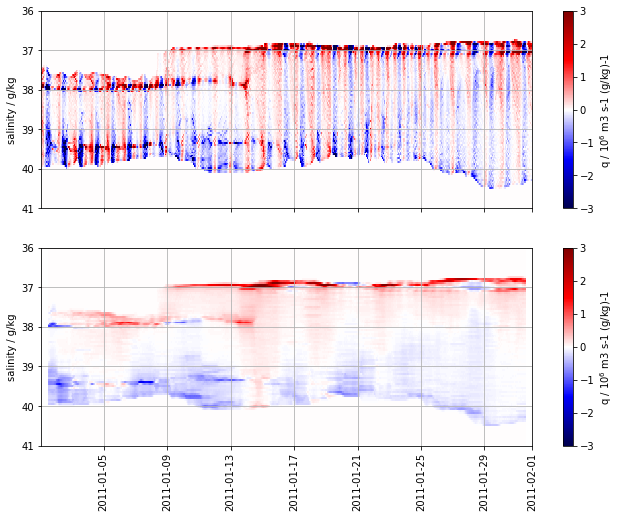

In [56]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(11, 8))
ax = ax.ravel()

vmax = 3.0

pcol = ax[0].pcolormesh(out1d_vol_transport_s.time,
                        out1d_vol_transport_s.var_q,
                        out1d_vol_transport_s.q.T/1000000,
                        cmap='seismic',
                        vmin=-vmax,
                        vmax=vmax)
ax[0].set_ylim(41,36) #invert salinity axis
ax[0].set_ylabel('salinity / g/kg')
ax[0].grid()
plt.colorbar(pcol,
             ax=ax[0],
             label='q / 10$^6$ m3 s-1 (g/kg)-1')
pcol = ax[1].pcolormesh(out1d_vol_transport_s.time,
                        out1d_vol_transport_s.var_q,
                        out1d_vol_transport_s.q
                        .rolling(time=24, center=True)
                        .mean().T/1000000,
                        cmap='seismic',
                        vmin=-vmax,
                        vmax=vmax)
ax[1].set_ylabel('salinity / g/kg')
ax[1].grid()
ax[1].set_ylim(41,36)
plt.xticks(rotation=90)
plt.colorbar(pcol, ax=ax[1], label='q / 10$^6$ m3 s-1 (g/kg)-1')

One can nicely see the variability of the exchange flow: The range in salinity changes, e.g. around January 9th Indian Ocean Surface Water with  a salinity of 37 g/kg arrives again at the transect. 
In addition, a clear tidal signal is present, i.e., inflow and outflow are alternating. When smoothing, by applying a window mean of 24 hours (bottom panel) the diurnal tides are filtered out and variability on larger time scales is more distinctly seen, e.g., the period of ~4 days.

Let's now compute the time series of bulk values:

In [57]:
out1d_vol_transport_s

<xarray.Dataset>
Dimensions:  (time: 744, var_Q: 101, var_q: 100)
Coordinates:
  * time     (time) datetime64[ns] 2011-01-01T01:00:00 ... 2011-02-01
  * var_q    (var_q) float64 36.02 36.07 36.12 36.17 ... 40.83 40.88 40.93 40.98
  * var_Q    (var_Q) float64 36.0 36.05 36.1 36.15 ... 40.85 40.9 40.95 41.0
Data variables:
    q        (time, var_q) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Q        (time, var_Q) float64 1.193e+06 1.193e+06 1.193e+06 ... 0.0 0.0 0.0

In [58]:
bulk_vol_s = tef.calc_bulk_values(out1d_vol_transport_s.var_Q,
                                  out1d_vol_transport_s.Q)

100%|██████████| 744/744 [02:03<00:00,  6.01it/s]


In [59]:
bulk_salt_s = tef.calc_bulk_values(out1d_salt_transport_s.var_Q,
                                   out1d_salt_transport_s.Q,
                                   index=bulk_vol_s.index)

100%|██████████| 744/744 [00:02<00:00, 342.10it/s]


In [60]:
bulk_vol_s

<xarray.Dataset>
Dimensions:  (m: 10, n: 10, o: 11, time: 744)
Coordinates:
  * time     (time) datetime64[ns] 2011-01-01T01:00:00 ... 2011-02-01
  * m        (m) int64 0 1 2 3 4 5 6 7 8 9
  * n        (n) int64 0 1 2 3 4 5 6 7 8 9
  * o        (o) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    Qin      (time, m) float64 1.193e+06 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Qout     (time, n) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    divval   (time, o) float64 37.5 40.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    index    (time, o) int64 30 80 0 0 0 0 0 0 0 0 0 ... 66 86 0 0 0 0 0 0 0 0

For the monthly mean bulk values, we have seen that the exchange flow is following a two-layer exchange in both T and S. But on hourly scales we find some cases, where there is more than one inflow and/or more than one outflow (strongly depending on Q_thresh). We further find cases, where there is no inflow or no outflow due to the tides.

(36.0, 41.0)

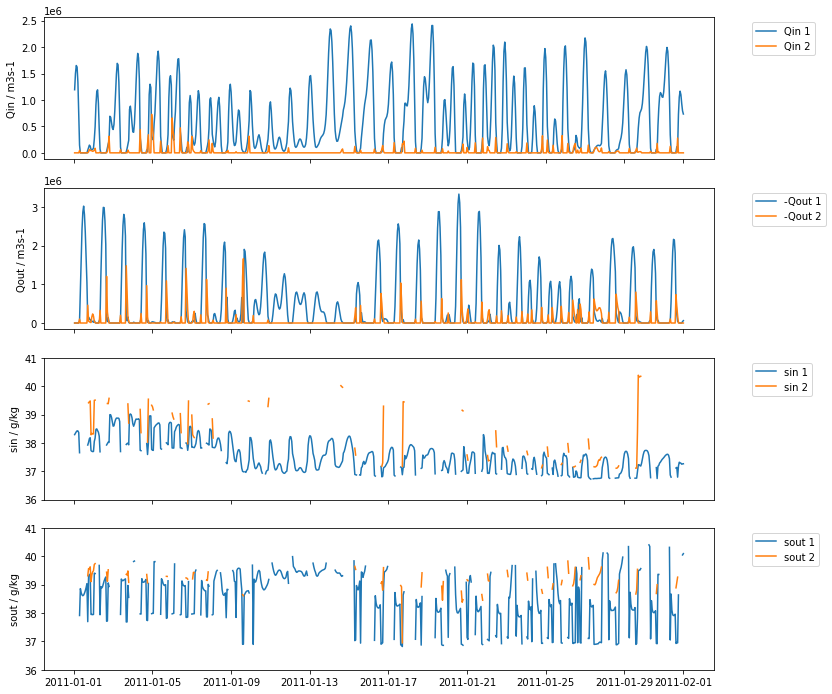

In [61]:
s_in  = bulk_salt_s.Qin / bulk_vol_s.Qin
s_out = bulk_salt_s.Qout / bulk_vol_s.Qout

fig,ax = plt.subplots(4,1,figsize=(12,12),sharex=True)

for i in range(2):
    ax[0].plot(bulk_vol_s.time, bulk_vol_s.Qin[:,i], label='Qin '+str(i+1))
    ax[1].plot(bulk_vol_s.time, -bulk_vol_s.Qout[:,i], label='-Qout '+str(i+1))
    ax[2].plot(bulk_vol_s.time, s_in[:,i], label='sin '+str(i+1))
    ax[3].plot(bulk_vol_s.time, s_out[:,i], label='sout '+str(i+1))

ax[0].legend(loc='upper left', bbox_to_anchor=(1.05, 1))
ax[1].legend(loc='upper left', bbox_to_anchor=(1.05, 1))
ax[2].legend(loc='upper left', bbox_to_anchor=(1.05, 1))
ax[3].legend(loc='upper left', bbox_to_anchor=(1.05, 1))
ax[0].set_ylabel('Qin / m3s-1')
ax[1].set_ylabel('Qout / m3s-1')
ax[2].set_ylabel('sin / g/kg')
ax[3].set_ylabel('sout / g/kg')

ax[2].set_ylim(36,41)
ax[3].set_ylim(36,41)

To combine the multilayer bulk values to one value, one can simply sum over the second axis:

In [62]:
Q_in = bulk_vol_s.Qin.sum(axis=1)
Qs_in = bulk_salt_s.Qin.sum(axis=1)
Q_out = bulk_vol_s.Qout.sum(axis=1)
Qs_out = bulk_salt_s.Qout.sum(axis=1)

s_in = Qs_in / Q_in
s_out= Qs_out / Q_out

(36.0, 41.0)

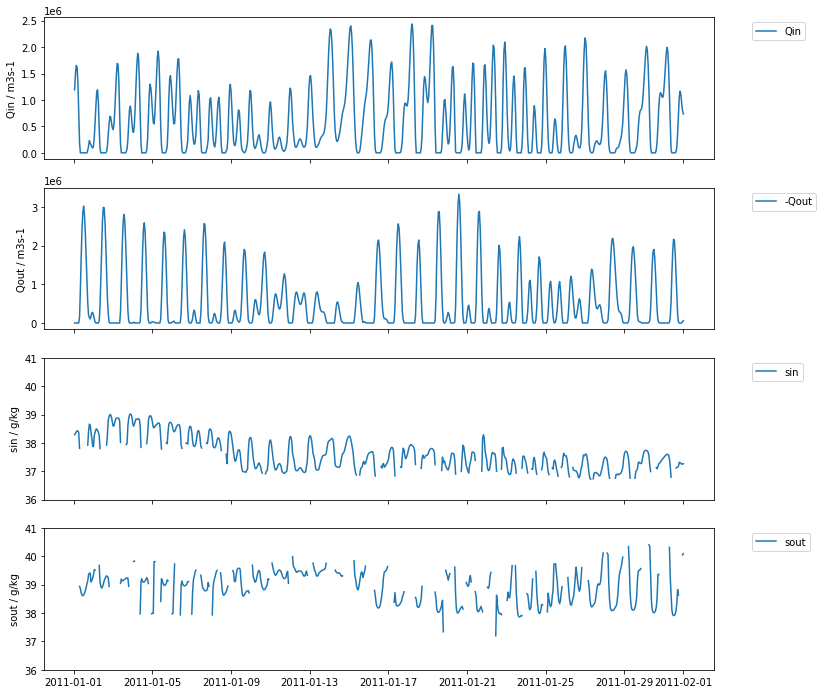

In [63]:
fig,ax = plt.subplots(4,1,figsize=(12,12),sharex=True)
ax[0].plot(bulk_vol_s.time,Q_in,label='Qin')
ax[1].plot(bulk_vol_s.time,-Q_out,label='-Qout')
ax[2].plot(bulk_vol_s.time,s_in,label='sin')
ax[3].plot(bulk_vol_s.time,s_out,label='sout')

ax[0].legend(loc='upper left',bbox_to_anchor=(1.05, 1))
ax[1].legend(loc='upper left',bbox_to_anchor=(1.05, 1))
ax[2].legend(loc='upper left',bbox_to_anchor=(1.05, 1))
ax[3].legend(loc='upper left',bbox_to_anchor=(1.05, 1))
ax[0].set_ylabel('Qin / m3s-1')
ax[1].set_ylabel('Qout / m3s-1')
ax[2].set_ylabel('sin / g/kg')
ax[3].set_ylabel('sout / g/kg')

ax[2].set_ylim(36,41)
ax[3].set_ylim(36,41)

Yet, this still has a lot of missing 0 included since the dirnal tides are so strong. One **must not** smooth the bulk values, but has to smooth Q and compute the bulk values again from the smooth Q! We do this again by using the rolling function of xarray.

In [ ]:
bulk_vol_s = tef.calc_bulk_values(out1d_vol_transport_s.var_Q,
                                  out1d_vol_transport_s.Q
                                  .rolling(time=24, center=True)
                                  .mean(),
                                  Q_thresh=10000.0)

bulk_salt_s = tef.calc_bulk_values(out1d_salt_transport_s.var_Q,
                                   out1d_salt_transport_s.Q
                                   .rolling(time=24, center=True)
                                   .mean(),
                                   index=bulk_vol_s.index)

 47%|████▋     | 347/744 [00:56<01:01,  6.46it/s]

In [ ]:
Q_in = bulk_vol_s.Qin.sum(axis=1)
Qs_in = bulk_salt_s.Qin.sum(axis=1)
Q_out = bulk_vol_s.Qout.sum(axis=1)
Qs_out = bulk_salt_s.Qout.sum(axis=1)

s_in = Qs_in / Q_in
s_out= Qs_out / Q_out

fig, ax = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
ax[0].plot(bulk_vol_s.time,Q_in,label='Qin')
ax[1].plot(bulk_vol_s.time,-Q_out,label='-Qout')
ax[2].plot(bulk_vol_s.time,s_in,label='sin')
ax[3].plot(bulk_vol_s.time,s_out,label='sout')

ax[0].legend(loc='upper left',bbox_to_anchor=(1.05, 1))
ax[1].legend(loc='upper left',bbox_to_anchor=(1.05, 1))
ax[2].legend(loc='upper left',bbox_to_anchor=(1.05, 1))
ax[3].legend(loc='upper left',bbox_to_anchor=(1.05, 1))
ax[0].set_ylabel('Qin / m3s-1')
ax[1].set_ylabel('Qout / m3s-1')
ax[2].set_ylabel('sin / g/kg')
ax[3].set_ylabel('sout / g/kg')

ax[2].set_ylim(36, 42)
ax[3].set_ylim(36, 42)

plt.show()

Filtering out the diurnal tides, one can more clearly see the signals of larger time scales. Still, there is a period of no outflow, which corresponds to a very large inflow.